In [1]:
from utils import spark
from pyspark.sql import functions as F
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt

23/06/04 17:14:44 WARN Utils: Your hostname, kayaba-kayaba resolves to a loopback address: 127.0.1.1; using 192.168.18.183 instead (on interface wlp3s0)
23/06/04 17:14:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/06/04 17:14:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load data

In [2]:
%%time
rating_df=spark.read.csv('data/ratings.csv',header=True)
tags_df=spark.read.csv("data/tags.csv",header=True)
title_df=spark.read.csv("data/movies.csv",header=True)

CPU times: user 9.91 ms, sys: 1.92 ms, total: 11.8 ms
Wall time: 10.8 s


In [3]:
%%time
print("jumlah User yang memberikan rating:",rating_df.select("userId").distinct().count())
print("Jumlah tidak ada Movies:",rating_df.select("movieId").distinct().count())
print("jumlah yang tidak ada tag ratings:",rating_df.select("rating").count())
print("Jumlah user yang tidak komentar:",tags_df.select("tag").distinct().count())
print("Jumlah film yang tidak komentar:",tags_df.select("movieId").distinct().count())
print("pesentasi pengguna yang berkomentar:",
      tags_df.select("tag").distinct().count()
      / rating_df.select("userId").distinct().count()*100)
print("persentasi film yang tidal berkomentar oleh user:",tags_df.select('movieId').distinct().count()
      / rating_df.select("movieId").distinct().count())

jumlah User yang memberikan rating: 162541


Jumlah tidak ada Movies: 59047


jumlah yang tidak ada tag ratings: 25000095


Jumlah user yang tidak komentar: 73051


Jumlah film yang tidak komentar: 45251


pesentasi pengguna yang berkomentar: 44.94312204305375


persentasi film yang tidal berkomentar oleh user: 0.7663556150185445
CPU times: user 54.8 ms, sys: 31 ms, total: 85.8 ms
Wall time: 1min 40s


In [4]:
rating_df=rating_df.drop('timestamp')
tags_df=tags_df.drop('timestamp')

In [5]:
title_df=title_df.withColumn("Year",F.regexp_extract("title",r'\((\d{4})\)',1))
title_df.show(n=3,truncate=False)

+-------+-----------------------+-------------------------------------------+----+
|movieId|title                  |genres                                     |Year|
+-------+-----------------------+-------------------------------------------+----+
|1      |Toy Story (1995)       |Adventure|Animation|Children|Comedy|Fantasy|1995|
|2      |Jumanji (1995)         |Adventure|Children|Fantasy                 |1995|
|3      |Grumpier Old Men (1995)|Comedy|Romance                             |1995|
+-------+-----------------------+-------------------------------------------+----+
only showing top 3 rows



In [6]:
# sss.show()

In [7]:
from pyspark.sql.functions import col, split, expr
# Separate genre into each column
split_cols = [split(col('genres'), '\|').getItem(i).alias(f'genre{i+1}') for i in range(10)]
split_cols.insert(0, col('movieId'))  # Add 'movieId' as the first column
sss = title_df.select(*split_cols, 'title', 'year')

# Count genres (non-zero values)
genre_columns = [col(f'genre{i+1}') for i in range(10)]
genre_count_expr = sum((col_name.isNotNull().cast(IntegerType())) for col_name in genre_columns)
title_df = sss.withColumn('genre_count', genre_count_expr)
title_df.show(3)


+-------+---------+---------+--------+------+-------+------+------+------+------+-------+--------------------+----+-----------+
|movieId|   genre1|   genre2|  genre3|genre4| genre5|genre6|genre7|genre8|genre9|genre10|               title|year|genre_count|
+-------+---------+---------+--------+------+-------+------+------+------+------+-------+--------------------+----+-----------+
|      1|Adventure|Animation|Children|Comedy|Fantasy|  null|  null|  null|  null|   null|    Toy Story (1995)|1995|          5|
|      2|Adventure| Children| Fantasy|  null|   null|  null|  null|  null|  null|   null|      Jumanji (1995)|1995|          3|
|      3|   Comedy|  Romance|    null|  null|   null|  null|  null|  null|  null|   null|Grumpier Old Men ...|1995|          2|
+-------+---------+---------+--------+------+-------+------+------+------+------+-------+--------------------+----+-----------+
only showing top 3 rows



In [8]:
rating_df.show(3)

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|    296|   5.0|
|     1|    306|   3.5|
|     1|    307|   5.0|
+------+-------+------+
only showing top 3 rows



In [9]:
from pyspark.sql.functions import avg, count

# Avg movie ratings by movieId and count
rating_avg = rating_df.groupBy('movieId').agg(avg('rating').alias('avg_rating'))
rating_count = rating_df.groupBy('movieId').agg(count('rating').alias('rating_count'))

# Avg user ratings by userId and count
user_rating = rating_df.groupBy('userId').agg(avg('rating').alias('avg_rating'))
user_count = rating_df.groupBy('userId').agg(count('rating').alias('rating_count'))

# Convert to PySpark DataFrames
rating_avg = rating_avg.withColumnRenamed('movieId', 'movieId')
rating_count = rating_count.withColumnRenamed('movieId', 'movieId').withColumnRenamed('rating_count', 'rating_count')
user_rating = user_rating.withColumnRenamed('userId', 'userId')
user_count = user_count.withColumnRenamed('userId', 'userId').withColumnRenamed('rating_count', 'rating_count')

# Merge DataFrames
df_movie = rating_avg.join(rating_count, 'movieId', 'inner')
df_movie = df_movie.orderBy('avg_rating', ascending=True)
df_user = user_rating.join(user_count, 'userId', 'inner')
df_user = df_user.orderBy('avg_rating', ascending=True)

In [10]:
df_user.show(4)

+------+----------+------------+
|userId|avg_rating|rating_count|
+------+----------+------------+
| 10364|       0.5|          20|
| 61102|       0.5|          20|
| 38998|       0.5|          20|
| 63044|       0.5|          20|
+------+----------+------------+
only showing top 4 rows



In [11]:
df_movie.show(4)

+-------+----------+------------+
|movieId|avg_rating|rating_count|
+-------+----------+------------+
| 203264|       0.5|           1|
| 197471|       0.5|           1|
| 207475|       0.5|           1|
| 179185|       0.5|           1|
+-------+----------+------------+
only showing top 4 rows



In [12]:
title_df.columns

['movieId',
 'genre1',
 'genre2',
 'genre3',
 'genre4',
 'genre5',
 'genre6',
 'genre7',
 'genre8',
 'genre9',
 'genre10',
 'title',
 'year',
 'genre_count']

In [13]:
cols = ['movieId','genre1']
dfk = title_df.select(*[col(c) for c in cols])
gabung_tag=tags_df.join(dfk,on="movieId",how='inner')
gabung_tag.show()

+-------+------+--------------------+---------+
|movieId|userId|                 tag|   genre1|
+-------+------+--------------------+---------+
|    260|     3|             classic|   Action|
|    260|     3|              sci-fi|   Action|
|   1732|     4|         dark comedy|   Comedy|
|   1732|     4|      great dialogue|   Comedy|
|   7569|     4|    so bad it's good|   Action|
|  44665|     4|unreliable narrators|    Crime|
| 115569|     4|               tense|    Crime|
| 115713|     4|artificial intell...|    Drama|
| 115713|     4|       philosophical|    Drama|
| 115713|     4|               tense|    Drama|
| 148426|     4|    so bad it's good|    Drama|
| 164909|     4|              cliche|   Comedy|
| 164909|     4|             musical|   Comedy|
| 168250|     4|              horror|   Horror|
| 168250|     4|       unpredictable|   Horror|
|   2160|    19|Oscar (Best Suppo...|    Drama|
|   7099|    19|           adventure|Adventure|
|   7099|    19|               anime|Adv

In [14]:
user_tags=tags_df.groupBy('userId', 'movieId').agg(F.count('tag').alias('tag_count'))
max_tag_count = user_tags.agg(F.max('tag_count')).first()[0]

# Filter the user_tags DataFrame to get rows with maximum tag count
user_tags_max = user_tags.filter(user_tags.tag_count == max_tag_count)

user_tags_max.show()

+------+-------+---------+
|userId|movieId|tag_count|
+------+-------+---------+
| 31047|    318|      337|
+------+-------+---------+



In [15]:
from pyspark.sql import functions as F

# Calculate tag count for each user
user_tagcount = tags_df.groupBy('userId').agg(F.count('tag').alias('tag_count'))

user_tagcount.show(3)


+------+---------+
|userId|tag_count|
+------+---------+
|  7273|       31|
| 11888|        3|
| 13282|        6|
+------+---------+
only showing top 3 rows



In [16]:
from pyspark.sql import functions as F

# Calculate tag count for each movie
movie_tagcount = tags_df.groupBy('movieId').agg(F.count('tag').alias('tag_count'))

# Join with movie data to get year and genres
movie_data = title_df.select('movieId', 'Year', 'genre1', 'genre2', 'genre3', 'genre4', 'genre5', 'genre6', 'genre7', 'genre8', 'genre9', 'genre10')
movie_tagcount = movie_tagcount.join(movie_data, 'movieId', 'left')

movie_tagcount.show(3)

+-------+---------+----+------+------+--------+--------+------+------+------+------+------+-------+
|movieId|tag_count|Year|genre1|genre2|  genre3|  genre4|genre5|genre6|genre7|genre8|genre9|genre10|
+-------+---------+----+------+------+--------+--------+------+------+------+------+------+-------+
| 115713|     2115|2015| Drama|Sci-Fi|Thriller|    null|  null|  null|  null|  null|  null|   null|
|    296|     4767|1994|Comedy| Crime|   Drama|Thriller|  null|  null|  null|  null|  null|   null|
| 177595|       14|1958|Horror|Sci-Fi|    null|    null|  null|  null|  null|  null|  null|   null|
+-------+---------+----+------+------+--------+--------+------+------+------+------+------+-------+
only showing top 3 rows



In [17]:
from pyspark.sql.functions import col

# Select columns from df3
df3_cols = ['movieId', 'genre_count', 'genre1']
dfs = title_df.select(*df3_cols)

# Join movie_tagcount with dfs
movie_tagcount = movie_tagcount.join(dfs, on='movieId', how='inner')

movie_tagcount.show(3)


+-------+---------+----+------+------+--------+--------+------+------+------+------+------+-------+-----------+------+
|movieId|tag_count|Year|genre1|genre2|  genre3|  genre4|genre5|genre6|genre7|genre8|genre9|genre10|genre_count|genre1|
+-------+---------+----+------+------+--------+--------+------+------+------+------+------+-------+-----------+------+
| 115713|     2115|2015| Drama|Sci-Fi|Thriller|    null|  null|  null|  null|  null|  null|   null|          3| Drama|
|    296|     4767|1994|Comedy| Crime|   Drama|Thriller|  null|  null|  null|  null|  null|   null|          4|Comedy|
| 177595|       14|1958|Horror|Sci-Fi|    null|    null|  null|  null|  null|  null|  null|   null|          2|Horror|
+-------+---------+----+------+------+--------+--------+------+------+------+------+------+-------+-----------+------+
only showing top 3 rows



In [18]:
from pyspark.sql.functions import col

# Join df3 with df_movie
df3 = title_df.join(df_movie, on='movieId', how='inner')

# Rename column
df3 = df3.withColumnRenamed('rating', 'avg_rating')

df3.show(3)


+-------+-----------+------+--------+------+------+------+------+------+------+-------+-------------------+----+-----------+------------------+------------+
|movieId|     genre1|genre2|  genre3|genre4|genre5|genre6|genre7|genre8|genre9|genre10|              title|year|genre_count|        avg_rating|rating_count|
+-------+-----------+------+--------+------+------+------+------+------+------+-------+-------------------+----+-----------+------------------+------------+
| 100008|Documentary|  null|    null|  null|  null|  null|  null|  null|  null|   null|   Flaw, The (2011)|2011|          1|3.5714285714285716|          14|
| 100040|      Crime| Drama|Thriller|  null|  null|  null|  null|  null|  null|   null|  True Blue (2001) |2001|          3|2.6666666666666665|           3|
| 100054|      Drama|  null|    null|  null|  null|  null|  null|  null|  null|   null|Stella Maris (1918)|1918|          1|               3.3|           5|
+-------+-----------+------+--------+------+------+------+

## Summary statistics to have some more insights

In [19]:
from pyspark.sql.functions import col

# Join df3 with df_movie
df3 = df3.join(df_movie, on='movieId', how='inner')

# Rename column
df3 = df3.withColumnRenamed('rating', 'avg_rating')

df3.show(3)


+-------+-----------+------+--------+------+------+------+------+------+------+-------+-------------------+----+-----------+------------------+------------+------------------+------------+
|movieId|     genre1|genre2|  genre3|genre4|genre5|genre6|genre7|genre8|genre9|genre10|              title|year|genre_count|        avg_rating|rating_count|        avg_rating|rating_count|
+-------+-----------+------+--------+------+------+------+------+------+------+-------+-------------------+----+-----------+------------------+------------+------------------+------------+
| 100008|Documentary|  null|    null|  null|  null|  null|  null|  null|  null|   null|   Flaw, The (2011)|2011|          1|3.5714285714285716|          14|3.5714285714285716|          14|
| 100040|      Crime| Drama|Thriller|  null|  null|  null|  null|  null|  null|   null|  True Blue (2001) |2001|          3|2.6666666666666665|           3|2.6666666666666665|           3|
| 100054|      Drama|  null|    null|  null|  null|  nu

# Data Visual

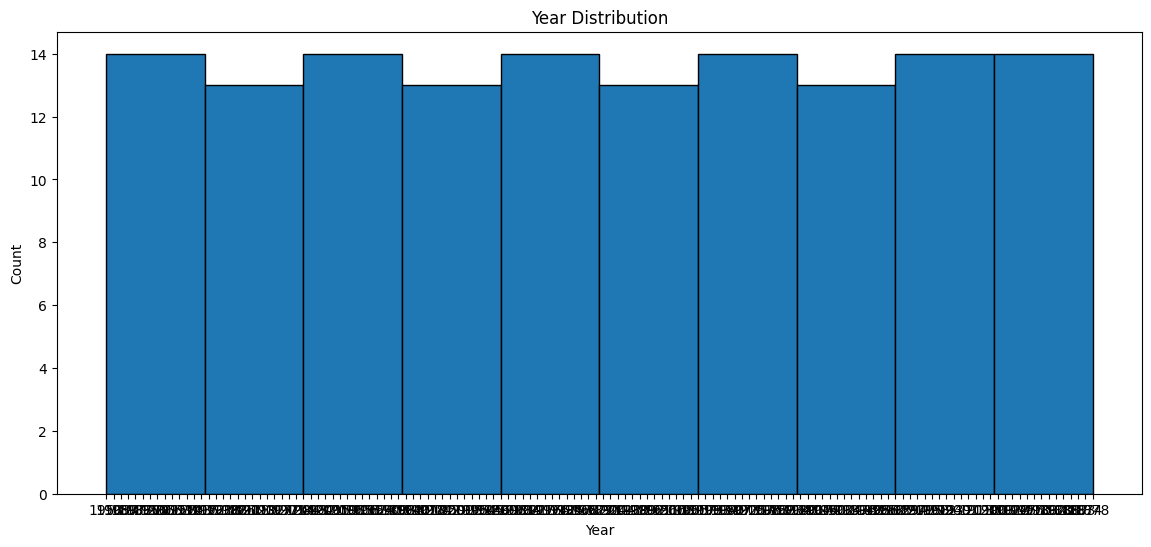

In [20]:
import matplotlib.pyplot as plt

# Collect histogram data
hist_data = df3.select('Year').groupBy('Year').count().toPandas()

# Set plot parameters
plt.figure(figsize=(14, 6))
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Year Distribution')

# Create histogram using Matplotlib
plt.hist(hist_data['Year'], bins=10, edgecolor='black')

# Show the plot
plt.show()


In [21]:
from pyspark.sql.functions import col
genre_count = df3.groupBy("genre1").count().alias("Count")
genre_count = genre_count.select(col('genre1').alias('genre'),col('Count'))
genre_count.show(3)

+--------+-----+
|   genre|Count|
+--------+-----+
|   Crime| 2845|
| Romance|  376|
|Thriller|  884|
+--------+-----+
only showing top 3 rows

